Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## 1. Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys,os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img

In [2]:
## Loading of data from the google drive
#from google.colab import drive
#drive.mount('/content/gdrive')
#root_path = 'gdrive/My Drive/MLC36/Assignment_Data/'  #change dir to your project folder

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
 # Train and Test data has been kept in A_data folder in same directory as the notebook

# Defining the path for train and test images
data_dir_train = pathlib.Path('A_data\Train')
data_dir_test = pathlib.Path('A_data\Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## 2. Loading the Dataset using keras.preprocessing

In [5]:
### Defining the Batch size and image size in the dataset
batch_size = 32
img_height = 180
img_width = 180

In [6]:
## Training Dataset (80 %)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Validation Dataset (20 %)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List of the classes of skin cancer in given dataset is diplayed. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3. Visualizing the Nine classes present in dataset

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


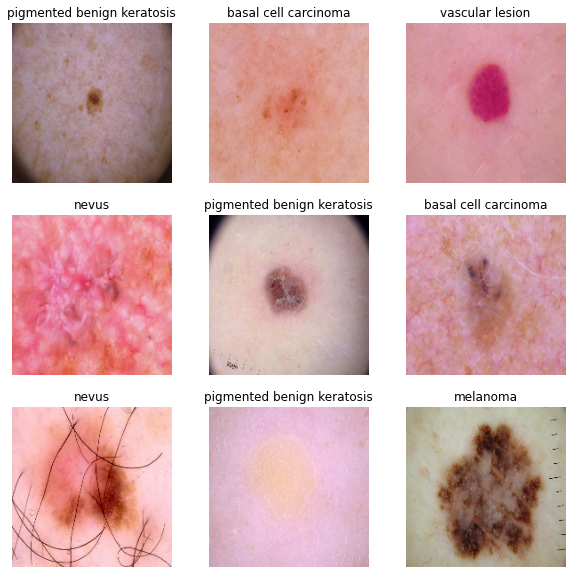

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## 4. Configuration setting for better performance

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 5. Model Building and Training (First Model)

### A. Model Building (First Model)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))


#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

### B. Model  Compile (First Model)

In [ ]:
model.compile(optimizer='adam', # Optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function
              metrics=['accuracy']) # Metric for checking Model accuracy

### C. Model Training  (First Model)

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

### D. Visualizing Training Results  (First Model)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###  E. Observations on the Results  (First Model)

-  The **Training accuracy** of the model is **84%**. But the **Validation accuracy** is **53%**.
-  The high validation loss not could be indicative of some **Overfit** in the model.
-  We could add some `Dropout` layers and `BatchNormalization` layers. 

## 6. Model Building and Training (Second Model)

###  A. Model Building  (Second Model with Dropout & Batch Normalisation)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model_2 = Sequential()

model_2.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model_2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model_2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu')) #First BN layer
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 10% Fraction of the input units to drop.
model_2.add(layers.Dropout(0.1))

#Second Convulation Layer
model_2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model_2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))  #Second BN layer
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 20% Fraction of the input units to drop.
model_2.add(layers.Dropout(0.20))

#Third Convulation Layer
model_2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model_2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu')) #Third BN layer
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model_2.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model_2.add(layers.Flatten())

#Dense Layer
model_2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model_2.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model_2.add(layers.Dense(len(class_names),activation='softmax'))

model_2.summary()

In [ ]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### B. Model Compile (Second Model with Dropout & Batch Normalisation)

In [ ]:
model_2.compile(optimizer='adam', # Optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function
              metrics=['accuracy']) # Metric for checking Model accuracy

### C. Model Training (Second Model with Dropout & Batch Normalisation)

In [ ]:
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

### D. Visualizing the Results (Second Model with Dropout & Batch Normalisation)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###  E. Observations on the Results  (Second Model with Dropout & Batch Normalisation)

-  The **Training accuracy** of the model has reduced to **70%** and **Validation accuracy** reduced marginally to **52%**.
-  However the **Overfit** has reduced considerably in the model.
-  We would use **Data Augmentation** to improve the performance of the model. 

## 6. Model Building and Training (Third Model with Data Augmentation)

### A. Using image data augmentation: Specifying the Augmentation
as we do not have a large image dataset, we may augment the data artificially by introducing sample diversity
by applying random yet realistic transformations to the training images, such as random horizontal flipping or
small random rotations. This will give better exposure covering different aspects of the training data and will
help in reducing the overfitting.

In [ ]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

###  B. Visualizing the Augmented Data

In [ ]:
#Let's visualize the an augmented sample instance, by applying `data_augmentation`to the first image in the dataset:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

###  C. Building the Model (Third Model with Data Augmentation)

In [ ]:
model_3_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),   
    
    Dense(9, activation='softmax')
])

### D. Model Compile (Third Model with Data Augmentation)

In [ ]:
model_3_augmented.compile(optimizer='adam', # Optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function
              metrics=['accuracy']) # Metric for checking Model accuracy

### E. Model Training (Third Model with Data Augmentation)

In [ ]:
epochs = 20
history = model_3_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

### F. Visualizing the Results (Third Model with Data Augmentation)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###  E. Observations on the Results  (Third Model with Data Augmentation)

-  The model accuracy for **Train data set** has reduced to nearly **53%**.
-  The accuracy for the **Validation set** has also marginally reduced to **50%**.
-  This is a much better model compared to the previous two models as there seems to almost **No Overfit** with the - ------  training accuracy **53%** and validation accuracy at **50%**.
-  **Data Augmentation** has improved the model performance.

## 7. Checking the Class Distribution or Class Imbalance in the dataset

#### Practically speaking, real life datasets can have class imbalance. One class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [12]:
train_path = "Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    directory =train_path + i + '/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


###  A. Observations on Class Imbalance

-  There is a significant **Class Imbalance** as the samples of various classes are not in equal proportions..
-  The class with the least number of samples is `seborrheic keratosis` with **77** samples.
-  The class that dominates the data in terms of proportionate number of samples is `Pigmented Benign Keratosis` with     
-  **462** samples. 

###  B. Visualization of Class Imbalance

In [27]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

original_df = class_distribution_count(data_dir_train)
original_df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<AxesSubplot:xlabel='No. of Image', ylabel='Class'>

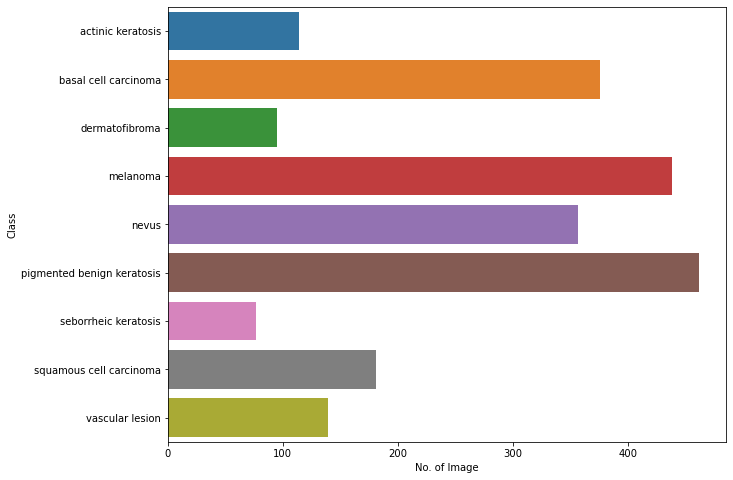

In [29]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=original_df,
            label="Class")

## 8. Rectifying the Class Imbalance in the dataset (Using Augmentor)

#### **Context:**  Using the python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

###  A. Installing the Augmentor

In [15]:
!pip install Augmentor


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

### B. Using Augmentor

In [17]:
path_to_training_dataset="A_data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|                                                                            | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to A_data/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18C7687E2E0>: 100%|███████████| 500/500 [00:10<00:00, 47.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18C742028B0>:   0%|             | 2/500 [00:00<01:26,  5.76 Samples/s]

Initialised with 376 image(s) found.
Output directory set to A_data/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x18C7676DA90>: 100%|█| 500/500 [00:10<00:00, 47.35 Sa
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18C76870280>:   1%|             | 4/500 [00:00<01:13,  6.73 Samples/s]

Initialised with 95 image(s) found.
Output directory set to A_data/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18C76898340>: 100%|███████████| 500/500 [00:12<00:00, 41.49 Samples/s]
Executing Pipeline:   0%|                                                                            | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to A_data/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x18C76787C40>: 100%|██████████| 500/500 [01:00<00:00,  8.21 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x18C7688B130>:   0%| | 1/500 [00:00<01:20,  6.23 Samp

Initialised with 357 image(s) found.
Output directory set to A_data/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2101x1943 at 0x18C762D31F0>: 100%|█| 500/500 [00:50<00:00,  9.92 
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x18C767871F0>:   1%| | 5/500 [00:00<01:18,  6.35 Samp

Initialised with 462 image(s) found.
Output directory set to A_data/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18C7419ED60>: 100%|███████████| 500/500 [00:12<00:00, 38.89 Samples/s]
Executing Pipeline:   0%|                                                                            | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to A_data/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x18C76284E20>: 100%|██████████| 500/500 [00:26<00:00, 18.54 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18C762B4D30>:   1%|             | 3/500 [00:00<01:10,  7.06 Samples/s]

Initialised with 181 image(s) found.
Output directory set to A_data/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18C762C5F70>: 100%|███████████| 500/500 [00:12<00:00, 40.86 Samples/s]
Executing Pipeline:   0%|                                                                            | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to A_data/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18C762A4910>: 100%|███████████| 500/500 [00:12<00:00, 40.65 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [19]:
data_dir_train = pathlib.Path('A_data/Train/')
data_dir_test = pathlib.Path('A_data/Test/')

In [20]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### C. Lets see the distribution of augmented data after adding new images to the original training data.

In [22]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['A_data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_14f21cc7-46c7-4a5c-bdde-ead6e66bfd09.jpg',
 'A_data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2a1ce231-da6a-441a-a97d-471e17a0d756.jpg',
 'A_data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c79051d9-c190-4995-aab4-bab6ac8c2cda.jpg',
 'A_data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c813ee02-a8c6-43ea-85aa-4eee03a07e78.jpg',
 'A_data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_306875df-b842-47c3-bb48-a93c50f4d529.jpg',
 'A_data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_31c27d66-7d52-45d1-a152-f37edc6094c8.jpg',
 'A_data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_332f7fd3-2501-40a6-be36-f34e712e913b.jpg',
 'A_data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803

In [23]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


In [25]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
train_path = "A_data/Train/"
for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [31]:
new_df['Label'].value_counts()

dermatofibroma                500
basal cell carcinoma          500
vascular lesion               500
seborrheic keratosis          500
squamous cell carcinoma       500
melanoma                      500
actinic keratosis             500
pigmented benign keratosis    500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## 9. Model Building and Training (Final Model with Augmentor data)

###  A. Load the Dataset

In [35]:
### Defining the Batch size and image size in the dataset
batch_size = 32
img_height = 180
img_width = 180

### B. Creating the Training dataset

In [36]:
data_dir_train="A_data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### C.  Create a Validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### D. Create your model (make sure to include normalization)

In [39]:
model_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),   
    
    Dense(9, activation='softmax')
])

### E.  Compile your model (Choose optimizer and loss function appropriately)

In [41]:
model_final.compile(optimizer='adam', # Optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function
              metrics=['accuracy']) # Metric for checking Model accuracy

### F.  Train your model

In [43]:
epochs = 30
history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 560s 3s/step - loss: 1.9760 - accuracy: 0.2318 - val_loss: 1.7339 - val_accuracy: 0.3697
Epoch 2/30
169/169 [==============================] - 553s 3s/step - loss: 1.6462 - accuracy: 0.3680 - val_loss: 1.6381 - val_accuracy: 0.3667
Epoch 3/30
169/169 [==============================] - 548s 3s/step - loss: 1.5697 - accuracy: 0.3919 - val_loss: 1.5603 - val_accuracy: 0.4120
Epoch 4/30
169/169 [==============================] - 548s 3s/step - loss: 1.4350 - accuracy: 0.4499 - val_loss: 1.3052 - val_accuracy: 0.4855
Epoch 5/30
169/169 [==============================] - 548s 3s/step - loss: 1.3321 - accuracy: 0.4915 - val_loss: 1.2917 - val_accuracy: 0.5182
Epoch 6/30
169/169 [==============================] - 548s 3s/step - loss: 1.1676 - accuracy: 0.5530 - val_loss: 1.0832 - val_accuracy: 0.5716
Epoch 7/30
169/169 [==============================] - 556s 3s/step - loss: 1.0801 - accuracy: 0.5972 - val_loss: 1.0936 - val_accuracy: 0.5976
Epoch 8/30

### G. Visualize the model results

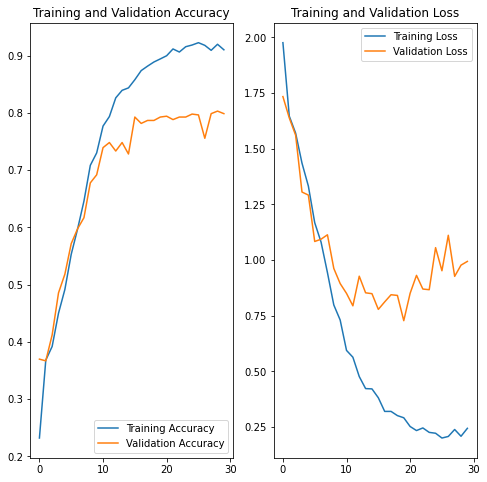

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### H. Observations (Final Model with Augmentor data)

- The **Training Accuracy** has now increased considerably from **53%** to **91%**.
- This is significant improvement after handling the Class Imbalance in the Train data.
- The accuracy for the **Validation set** has also increased from **50%** to **80%**.
- This is a much better model compared to the previous models considering the performance.
- The model still seems to have some **Overfitting** & needs fine tuning of hyperparameters or adding/reducing the layers.
- Though the model accuracy has improved, the **class rebalance** has helped **treat the overfitting to some extent**.
- Much better models could be built or tried out using **more epochs and more layers**.